# Visualize grit as compared to replicate reproducibility

Grit combines the concepts of replicate reproducibility and difference from controls.

Here, observe how grit handles the tradeoff between calculating each independently.

In [1]:
import pathlib
import pandas as pd
import plotnine as gg

from pycytominer.cyto_utils import infer_cp_features

from cytominer_eval.transform.transform import get_pairwise_metric, process_melt
from cytominer_eval.transform.util import set_pair_ids
from cytominer_eval.operations.util import assign_replicates

In [2]:
output_dir = pathlib.Path("figures/replicate_reproducibility")

cell_health_dir = pathlib.Path("../../1.calculate-metrics/cell-health/results")
grit_file = pathlib.Path(f"{cell_health_dir}/cell_health_grit.tsv")
non_replicate_cor_file = pathlib.Path(
    f"{cell_health_dir}/cell_health_nonreplicate_95thpercentile.tsv"
)
reprod_file = pathlib.Path(
    f"{cell_health_dir}/cell_health_replicate_reproducibility.tsv"
)

In [3]:
replicate_reproducibility_theme = gg.theme(
    strip_background=gg.element_rect(color="black", fill="#fdfff4"),
    strip_text_x=gg.element_text(size=6),
    axis_text=gg.element_text(size=7),
    axis_title=gg.element_text(size=8),
    legend_title=gg.element_text(size=6),
    legend_text=gg.element_text(size=5),
    legend_key_size=10,
    legend_key_width=10,
    legend_key_height=10,
    panel_grid=gg.element_line(size=0.35),
)

In [4]:
# Load and process data
grit_df = (
    pd.read_csv(grit_file, sep="\t")
    .query("barcode_control == 'cutting_control'")
    .query("cor_method == 'pearson'")
    .query("grit_replicate_summary_method == 'mean'")
)

reprod_df = pd.read_csv(reprod_file, sep="\t")

grit_df = grit_df.merge(
    reprod_df, on=["perturbation", "group", "cell_line"], how="inner"
).dropna()

grit_df = grit_df.assign(
    replicate_over_cor=grit_df.median_replicate_correlation
    / grit_df.median_control_correlation,
    replicate_over_oneminuscor=grit_df.median_replicate_correlation
    / (1 - grit_df.median_control_correlation),
)
grit_df.replicate_over_cor = grit_df.replicate_over_cor.abs()

print(grit_df.shape)
grit_df.head()

(339, 11)


,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,median_replicate_correlation,median_control_correlation,replicate_over_cor,replicate_over_oneminuscor
0,AKT1-1,AKT1,0.793952,HCC44,cutting_control,pearson,mean,0.312738,-0.015761,19.842424,0.307885
1,AKT1-2,AKT1,0.775840,HCC44,cutting_control,pearson,mean,0.152056,0.007979,19.057880,0.153279
2,ARID1B-1,ARID1B,0.448876,HCC44,cutting_control,pearson,mean,0.186862,0.054083,3.455095,0.197546
3,ARID1B-2,ARID1B,0.323462,HCC44,cutting_control,pearson,mean,0.211846,0.033912,6.246934,0.219283
4,ATF4-1,ATF4,0.214374,HCC44,cutting_control,pearson,mean,0.754919,0.118991,6.344323,0.856881


In [5]:
# Output results
non_rep_df = pd.read_csv(non_replicate_cor_file, sep="\t")
non_rep_df

,cell_line,similarity_metric
0,A549,0.528442
1,ES2,0.502821
2,HCC44,0.458500


/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 5 in image.
/Users/akalinin/Software/miniconda3/envs/grit-benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: figures/replicate_reproducibility/cell_health_grit_replicate_reproduce.png


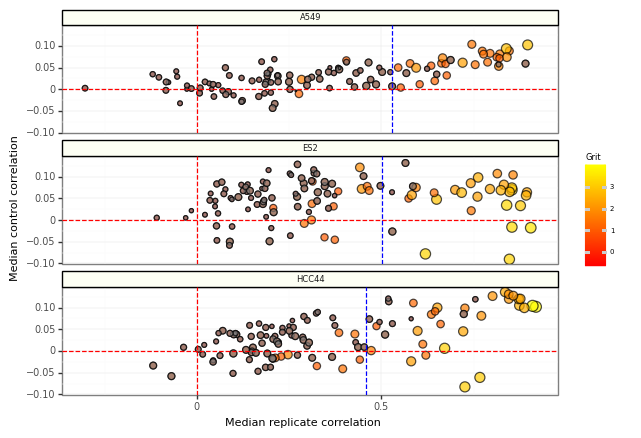

<ggplot: (674202060)>

In [6]:
replicate_gg = (
    gg.ggplot(
        grit_df,
        gg.aes(x="median_replicate_correlation", y="median_control_correlation"),
    )
    + gg.geom_point(gg.aes(fill="grit", size="grit"), alpha=0.7)
    + gg.geom_point(
        gg.aes(size="grit"), fill="grey", data=grit_df.query("grit < 1"), alpha=0.7
    )
    + gg.scale_fill_gradient(name="Grit", high="yellow", low="red")
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(
        gg.aes(xintercept="similarity_metric"),
        data=non_rep_df,
        linetype="dashed",
        color="blue",
    )
    + gg.xlab("Median replicate correlation")
    + gg.ylab("Median control correlation")
    + replicate_reproducibility_theme
)

output_file = pathlib.Path(f"{output_dir}/cell_health_grit_replicate_reproduce.png")
replicate_gg.save(output_file, dpi=500, height=5, width=3)

replicate_gg

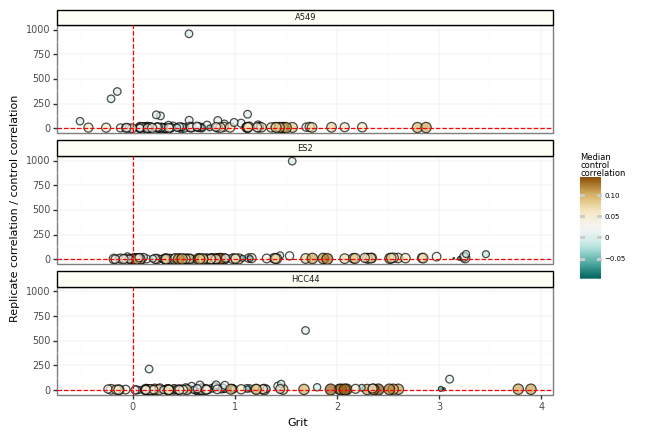

<ggplot: (677772751)>

In [7]:
replicate_gg = (
    gg.ggplot(grit_df, gg.aes(x="grit", y="replicate_over_cor"))
    + gg.geom_point(
        gg.aes(fill="median_control_correlation", size="median_control_correlation"),
        alpha=0.7,
    )
    + gg.scale_fill_distiller(name="Median\ncontrol\ncorrelation\n", type="div")
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / control correlation")
    + replicate_reproducibility_theme
)

replicate_gg

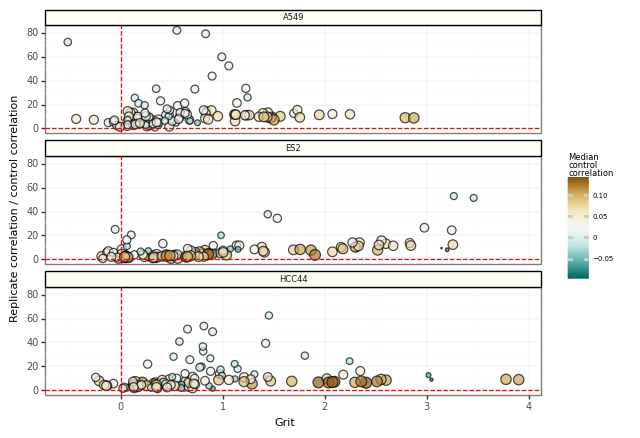

<ggplot: (679034850)>

In [8]:
replicate_gg = (
    gg.ggplot(
        grit_df.query("replicate_over_cor < 100"),
        gg.aes(x="grit", y="replicate_over_cor"),
    )
    + gg.geom_point(
        gg.aes(fill="median_control_correlation", size="median_control_correlation"),
        alpha=0.7,
    )
    + gg.scale_fill_distiller(name="Median\ncontrol\ncorrelation\n", type="div")
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / control correlation")
    + replicate_reproducibility_theme
)

replicate_gg

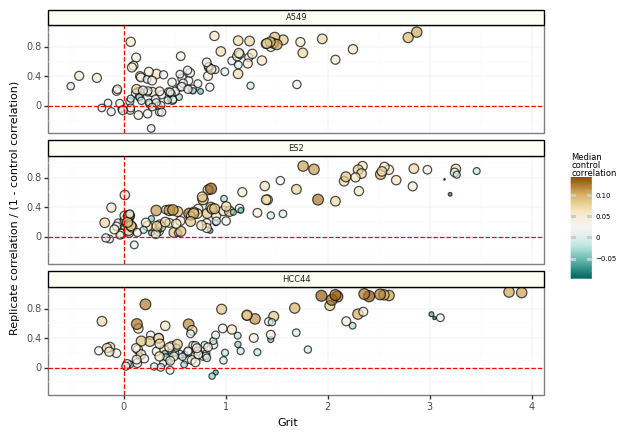

<ggplot: (679129401)>

In [9]:
replicate_gg = (
    gg.ggplot(grit_df, gg.aes(x="grit", y="replicate_over_oneminuscor"))
    + gg.geom_point(
        gg.aes(fill="median_control_correlation", size="median_control_correlation"),
        alpha=0.7,
    )
    + gg.scale_fill_distiller(name="Median\ncontrol\ncorrelation\n", type="div")
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / (1 - control correlation)")
    + replicate_reproducibility_theme
)

replicate_gg

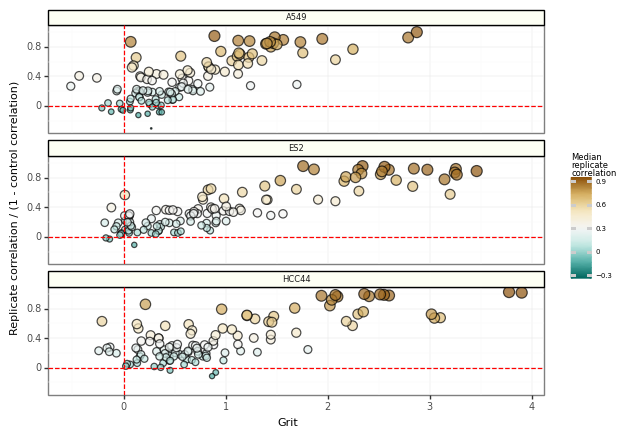

<ggplot: (679249314)>

In [10]:
replicate_gg = (
    gg.ggplot(grit_df, gg.aes(x="grit", y="replicate_over_oneminuscor"))
    + gg.geom_point(
        gg.aes(
            fill="median_replicate_correlation", size="median_replicate_correlation"
        ),
        alpha=0.7,
    )
    + gg.scale_fill_distiller(name="Median\nreplicate\ncorrelation\n", type="div")
    + gg.scale_size_continuous(guide=False, range=[0.1, 4], breaks=[0, 0.1, 2, 3, 5])
    + gg.facet_wrap("~cell_line", nrow=3)
    + gg.theme_bw()
    + gg.geom_hline(yintercept=0, linetype="dashed", color="red")
    + gg.geom_vline(xintercept=0, linetype="dashed", color="red")
    + gg.xlab("Grit")
    + gg.ylab("Replicate correlation / (1 - control correlation)")
    + replicate_reproducibility_theme
)

replicate_gg

In [11]:
grit_df.query("grit < 0").query("replicate_over_oneminuscor > 0.4")

,perturbation,group,grit,cell_line,barcode_control,cor_method,grit_replicate_summary_method,median_replicate_correlation,median_control_correlation,replicate_over_cor,replicate_over_oneminuscor
11,BCL2L2-1,BCL2L2,-0.211477,HCC44,cutting_control,pearson,mean,0.581016,0.074102,7.840781,0.627516
209,PPIB-2,PPIB,-0.434501,A549,cutting_control,pearson,mean,0.386948,0.048674,7.949825,0.406746


In [12]:
# Load Cell Health data
plate = "SQ00014613"
data_file = pathlib.Path(
    "../../1.calculate-metrics/cell-health/data/cell_health_merged_feature_select.csv.gz"
)

df = pd.read_csv(data_file, sep=",")

print(df.shape)
df.head(2)

(3456, 402)


,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_Zernike_0_0,...,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_20_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_ER_5_0,Nuclei_Texture_SumAverage_Mito_20_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0
0,SQ00014618,A01,1,A,HCC44,EMPTY,EMPTY,-1.515696,0.810956,1.984031,...,-1.365392,-0.351107,-0.163153,2.307568,-2.775524,-3.951667,-1.716353,-2.703082,-3.720976,0.107581
1,SQ00014618,A02,2,A,HCC44,MCL1,MCL1-5,0.246423,0.687241,0.062305,...,-0.070069,1.855687,-0.400335,3.776635,0.947498,-0.541032,0.363568,0.910251,-0.364015,0.165935


In [13]:
outlier_df = (
    df.query("Metadata_cell_line == 'A549'")
    .query("Metadata_gene_name in ['PPIB', 'Chr2', 'Luc', 'LacZ']")
    .reset_index(drop=True)
)

features = infer_cp_features(outlier_df)
meta_features = infer_cp_features(outlier_df, metadata=True)

outlier_df.head()

,Metadata_Plate,Metadata_Well,Metadata_WellCol,Metadata_WellRow,Metadata_cell_line,Metadata_gene_name,Metadata_pert_name,Cells_AreaShape_Compactness,Cells_AreaShape_Extent,Cells_AreaShape_Zernike_0_0,...,Nuclei_Texture_InverseDifferenceMoment_Mito_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_10_0,Nuclei_Texture_InverseDifferenceMoment_RNA_20_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_ER_5_0,Nuclei_Texture_SumAverage_Mito_20_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0
0,SQ00014611,B01,1,B,A549,Chr2,Chr2-1,0.043247,0.365683,0.072426,...,1.092272,0.233633,-1.140911,2.880912,0.779851,-1.225085,0.075470,0.973400,-0.740411,0.670231
1,SQ00014611,B02,2,B,A549,PPIB,PPIB-2,-1.911294,2.769495,1.532361,...,1.149812,1.316694,-0.422962,2.281556,2.085893,-0.558614,0.670240,1.855813,0.025328,0.634472
2,SQ00014611,B05,5,B,A549,Chr2,Chr2-4,0.255784,-0.112610,-0.032450,...,0.625421,-0.145690,-1.197467,0.345071,0.334329,-0.430931,0.813689,0.228340,0.059867,0.949044
3,SQ00014611,B08,8,B,A549,Chr2,Chr2-5,-0.916932,1.343534,0.890899,...,0.899412,1.190795,0.677378,1.337814,1.497355,0.580450,0.346023,1.342423,0.784393,-0.147944
4,SQ00014611,B12,12,B,A549,Chr2,Chr2-2,0.135337,0.000672,0.067788,...,0.282994,0.494315,0.538035,-0.051057,0.560541,0.176448,-0.235675,0.377312,0.020587,0.026949


In [14]:
pairwise_cor_df = process_melt(
    get_pairwise_metric(df=outlier_df.loc[:, features], similarity_metric="pearson"),
    meta_df=outlier_df.loc[:, meta_features],
)

pairwise_cor_df = assign_replicates(
    similarity_melted_df=pairwise_cor_df,
    replicate_groups=["Metadata_gene_name", "Metadata_pert_name", "Metadata_Plate"],
)

pairwise_cor_df

,Metadata_Plate_pair_a,Metadata_Well_pair_a,Metadata_WellCol_pair_a,Metadata_WellRow_pair_a,Metadata_cell_line_pair_a,Metadata_gene_name_pair_a,Metadata_pert_name_pair_a,Metadata_Plate_pair_b,Metadata_Well_pair_b,Metadata_WellCol_pair_b,...,Metadata_cell_line_pair_b,Metadata_gene_name_pair_b,Metadata_pert_name_pair_b,pair_a_index,pair_b_index,similarity_metric,Metadata_gene_name_replicate,Metadata_pert_name_replicate,Metadata_Plate_replicate,group_replicate
0,SQ00014611,B01,1,B,A549,Chr2,Chr2-1,SQ00014611,B02,2,...,A549,PPIB,PPIB-2,0,1,0.614525,False,False,True,False
1,SQ00014611,B01,1,B,A549,Chr2,Chr2-1,SQ00014611,B05,5,...,A549,Chr2,Chr2-4,0,2,0.094612,True,False,True,False
2,SQ00014611,B01,1,B,A549,Chr2,Chr2-1,SQ00014611,B08,8,...,A549,Chr2,Chr2-5,0,3,0.176308,True,False,True,False
3,SQ00014611,B01,1,B,A549,Chr2,Chr2-1,SQ00014611,B12,12,...,A549,Chr2,Chr2-2,0,4,0.050255,True,False,True,False
4,SQ00014611,B01,1,B,A549,Chr2,Chr2-1,SQ00014611,B13,13,...,A549,Luc,Luc-1,0,5,-0.262312,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28675,SQ00014612,P17,17,P,A549,Chr2,Chr2-5,SQ00014612,P23,23,...,A549,PPIB,PPIB-2,236,238,0.548734,False,False,True,False
28676,SQ00014612,P17,17,P,A549,Chr2,Chr2-5,SQ00014612,P24,24,...,A549,Chr2,Chr2-1,236,239,0.429429,True,False,True,False
28677,SQ00014612,P20,20,P,A549,Chr2,Chr2-4,SQ00014612,P23,23,...,A549,PPIB,PPIB-2,237,238,0.667223,False,False,True,False
28678,SQ00014612,P20,20,P,A549,Chr2,Chr2-4,SQ00014612,P24,24,...,A549,Chr2,Chr2-1,237,239,0.559035,True,False,True,False


In [15]:
(
    pairwise_cor_df.groupby(
        [
            "Metadata_cell_line_pair_a",
            "Metadata_gene_name_pair_a",
            "Metadata_pert_name_pair_a",
            "Metadata_Plate_pair_a",
            "group_replicate",
        ]
    )["similarity_metric"]
    .max()
    .reset_index()
    .sort_values(by="similarity_metric", ascending=False)
    .query("not group_replicate")
)

,Metadata_cell_line_pair_a,Metadata_gene_name_pair_a,Metadata_pert_name_pair_a,Metadata_Plate_pair_a,group_replicate,similarity_metric
70,A549,PPIB,PPIB-2,SQ00014612,False,0.935968
54,A549,Luc,Luc-2,SQ00014610,False,0.904846
14,A549,Chr2,Chr2-3,SQ00014611,False,0.884473
0,A549,Chr2,Chr2-1,SQ00014610,False,0.882013
34,A549,Chr2,Chr2-6,SQ00014612,False,0.879970
30,A549,Chr2,Chr2-6,SQ00014610,False,0.876675
16,A549,Chr2,Chr2-3,SQ00014612,False,0.875771
56,A549,Luc,Luc-2,SQ00014611,False,0.871779
66,A549,PPIB,PPIB-2,SQ00014610,False,0.868854
20,A549,Chr2,Chr2-4,SQ00014611,False,0.866609


In [16]:
(
    pairwise_cor_df.groupby(
        [
            "Metadata_cell_line_pair_a",
            "Metadata_pert_name_pair_a",
            "Metadata_Plate_pair_a",
            "group_replicate",
        ]
    )["similarity_metric"]
    .median()
    .reset_index()
)

,Metadata_cell_line_pair_a,Metadata_pert_name_pair_a,Metadata_Plate_pair_a,group_replicate,similarity_metric
0,A549,Chr2-1,SQ00014610,False,0.052724
1,A549,Chr2-1,SQ00014610,True,0.078510
2,A549,Chr2-1,SQ00014611,False,0.086500
3,A549,Chr2-1,SQ00014611,True,0.164432
4,A549,Chr2-1,SQ00014612,False,0.105627
...,...,...,...,...,...
67,A549,PPIB-2,SQ00014610,True,0.366082
68,A549,PPIB-2,SQ00014611,False,0.168483
69,A549,PPIB-2,SQ00014611,True,0.366000
70,A549,PPIB-2,SQ00014612,False,0.212676
